# Augmentation Consistency Score (ACS) - Notebook
# Name: Kim Meyers (021105204B)

### Imports

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np

plt.style.use("ggplot")

### Load results

In [10]:
# tabular ACS results
tabular_path = Path("tests/data/measures/acs_tabular_monai.csv")
tabular_df = pd.read_csv(tabular_path)

# CIFAR-100 ACS results
cifar_path = Path("tests/data/measures/acs_cifar100_models.csv")
cifar_df = pd.read_csv(cifar_path)

tabular_df, cifar_df

(                name  score                        time  feature_pid
 0          acs_monai  0.928  2025-11-26T17:10:34.913646          NaN
 1  accuracy_baseline  0.731  2025-11-26T17:10:34.913646          NaN
 2     accuracy_noisy  0.741  2025-11-26T17:10:34.913646          NaN
 3           acc_drop -0.010  2025-11-26T17:10:34.913646          NaN,
           model  acc_base  acc_aug    acs  acc_drop
 0    TinyCNN100     0.030    0.031  0.536    -0.001
 1  DeeperCNN100     0.018    0.018  0.644     0.000
 2  ResNet18_100     0.039    0.010  0.543     0.029)

### Plot Tabular ACS Results

                name  score                        time  feature_pid
0          acs_monai  0.928  2025-11-26T17:10:34.913646          NaN
1  accuracy_baseline  0.731  2025-11-26T17:10:34.913646          NaN
2     accuracy_noisy  0.741  2025-11-26T17:10:34.913646          NaN
3           acc_drop -0.010  2025-11-26T17:10:34.913646          NaN


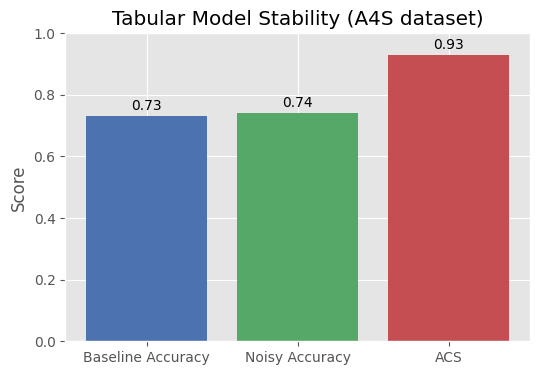

In [11]:
print(tabular_df.head())

scores = tabular_df.set_index("name")["score"]

acc_base = float(scores["accuracy_baseline"])
acc_noisy = float(scores["accuracy_noisy"])
acs_tab = float(scores["acs_monai"])

values = [acc_base, acc_noisy, acs_tab]
labels = ["Baseline Accuracy", "Noisy Accuracy", "ACS"]

plt.figure(figsize=(6,4))
plt.bar(labels, values, color=["#4C72B0", "#55A868", "#C44E52"])
plt.title("Tabular Model Stability (A4S dataset)")
plt.ylabel("Score")
plt.ylim(0, 1)
for i, v in enumerate(values):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()

This diagram shows how stable the tabular model is when small random noise is added to the data. The first bar is the normal accuracy of the model on clean data, the second shows the accuracy after adding noise, and the last bar is the ACS score, which tells how consistent the model stays. The ACS value of 0.93 means the model keeps its predictions almost the same even when the input is slightly changed.

### Tabular data before/after

In [12]:
df = pd.read_csv("tests/data/lcld_v2_test_400.csv")
num_features = df.select_dtypes(include=np.number).columns[:5]
sample = df[num_features].head(5)

# Add Gaussian noise
np.random.seed(42)
noisy = sample + np.random.normal(0, 0.05, sample.shape)

print("Data before (first 5 rows):")
display(sample)

print("After MONAI Gaussian Noise (std=0.05):")
display(noisy)

Data before (first 5 rows):


,loan_amnt,term,int_rate,installment,sub_grade
0,6000.0,36,12.12,199.63,7
1,8000.0,36,13.11,269.98,8
2,5800.0,36,12.12,192.98,7
3,3000.0,36,18.25,108.84,17
4,7000.0,36,6.03,213.05,0


After MONAI Gaussian Noise (std=0.05):


,loan_amnt,term,int_rate,installment,sub_grade
0,6000.024836,35.993087,12.152384,199.706151,6.988292
1,7999.988293,36.078961,13.148372,269.956526,8.027128
2,5799.976829,35.976714,12.132098,192.884336,6.913754
3,2999.971886,35.949358,18.265712,108.794599,16.929385
4,7000.073282,35.988711,6.033376,212.978763,-0.027219


The table shows how the data looks before and after adding small random noise with MONAI. The values after the noise are almost the same as before, only slightly changed. This helps to test if the model gives stable predictions when the input numbers are a bit different.

### Plot CIFAR-100 Results

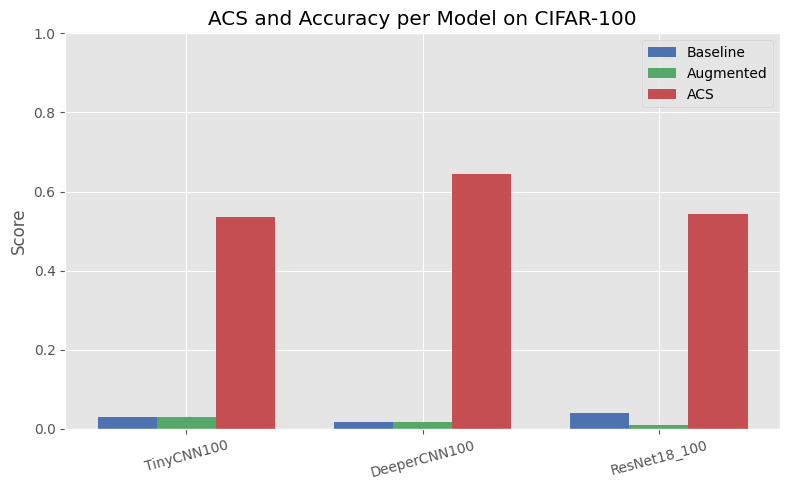

In [13]:
x = np.arange(len(cifar_df["model"]))
width = 0.25

plt.figure(figsize=(8,5))
plt.bar(x - width, cifar_df["acc_base"], width, label="Baseline", color="#4C72B0")
plt.bar(x, cifar_df["acc_aug"], width, label="Augmented", color="#55A868")
plt.bar(x + width, cifar_df["acs"], width, label="ACS", color="#C44E52")

plt.xticks(x, cifar_df["model"], rotation=15)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("ACS and Accuracy per Model on CIFAR-100")
plt.legend()
plt.tight_layout()
plt.show()

This graph shows how consistent each model is when we add small image changes using MONAI. The blue bars are the normal accuracy, the green bars are the accuracy after adding noise and blur, which is usually a bit lower because the task becomes harder, and the red bars are the ACS, which shows how stable the model is. Even if the accuracy is low, a higher ACS means the model reacts more consistently to small changes.

### Accuracy drop

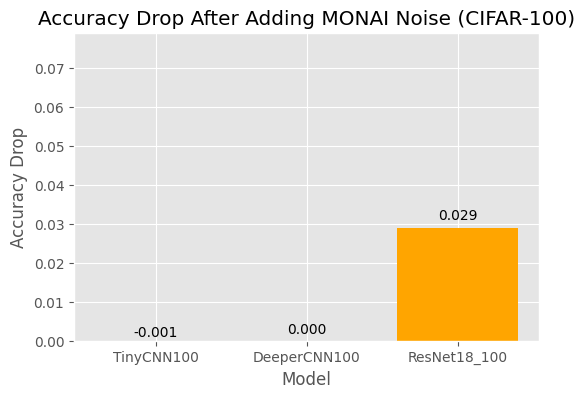

In [14]:
import pandas as pd

df = pd.read_csv(Path("tests/data/measures/acs_cifar100_models.csv"))

if "acc_drop" not in df.columns:
    df["acc_drop"] = df["acc_base"] - df["acc_aug"]

plt.figure(figsize=(6,4))
plt.bar(df["model"], df["acc_drop"], color="orange")
plt.title("Accuracy Drop After Adding MONAI Noise (CIFAR-100)")
plt.ylabel("Accuracy Drop")
plt.xlabel("Model")
for i, val in enumerate(df["acc_drop"]):
    plt.text(i, val + 0.002, f"{val:.3f}", ha="center")
plt.ylim(0, max(df["acc_drop"]) + 0.05)
plt.show()

This plot shows how much accuracy each model loses when small MONAI changes are added to the CIFAR-100 images. We can see that the ResNet18 model is the most affected, with a small accuracy drop, while the TinyCNN and DeeperCNN models stay almost the same. This means that some models are more sensitive to image changes, and the metric helps to detect this difference.

### Before / After Images

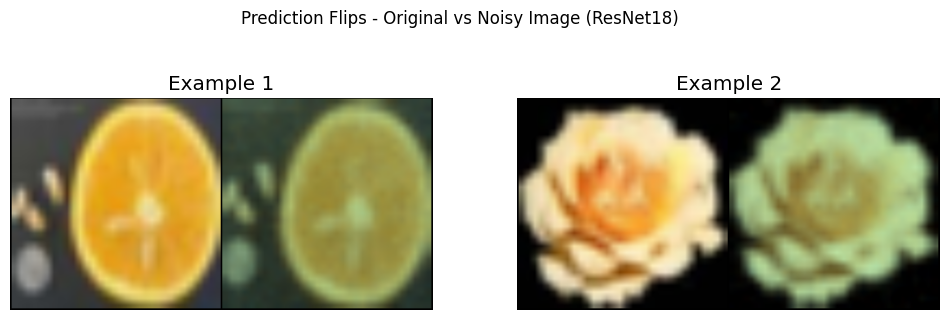

In [15]:
flip_root = Path("image_acs_flips_cifar100/ResNet18_100")
example_paths = list(flip_root.glob("*.png"))[:2]

plt.figure(figsize=(12,4))
for i, path in enumerate(example_paths):
    img = Image.open(path)
    plt.subplot(1, len(example_paths), i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Example {i+1}")
plt.suptitle("Prediction Flips - Original vs Noisy Image (ResNet18)")
plt.show()

This image shows two examples from the CIFAR-100 dataset. On the left of each pair is the original image, and on the right is the same image after adding small MONAI changes like blur and noise. These examples show that even if the images look almost the same to humans, the model sometimes changes its prediction, which means it is not fully stable.